# Computer Vision, Fall 2022

#### Name: Adam El Kholy

#### <font color='red'>Exercise 4, return latest on Sunday 9.10.2022 at 23.50 via Moodle</font>

Return the answer in PDF and Jupyter Notebook formats.

## Ex 4.1 Camera Calibration (2 p)

Please find the 3 sets of images provided in the Moodle page of this week's exercise. The three image sets (A,B and C) contain pictures taken of a camera calibration checkerboard pattern with a square size of 3cm.

1) Write a function using built-in OpenCV methods that computes the intrinsic camera calibration matrix and distortion matrix from a given set of calibration images.

2) Apply that function to all three sets of images and observe the results. Based on the results for the intrinsic and distortion matrix, discuss what type of camera or lens was used to capture the different image sets.

In [113]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)

In [114]:
def calibrate(img_path):
    matrix=None
    distortion=None
    # ... 8, 6
    objp = np.zeros((6*8,3), np.float32)
    objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob('{}/*.jpeg'.format(img_path))

    for filename in images:        
        image = cv2.imread(filename)
        grayColor = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(grayColor, (8,6), None)        

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, matrix, distortion, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, grayColor.shape[::-1], None, None)
    return matrix, distortion

In [115]:
print("Images A:")
matrix, distortion = calibrate("images_A")
print(matrix)
print(distortion)
print()

print("Images B:")
matrix, distortion = calibrate("images_B")
print(matrix)
print(distortion)
print()

print("Images C:")
matrix, distortion = calibrate("images_C")
print(matrix)
print(distortion)

Images A:
[[3446.7569096     0.         1607.51829911]
 [   0.         3444.71934455 1925.74398752]
 [   0.            0.            1.        ]]
[[ 0.20821615 -0.90660314 -0.00647741  0.00994418  2.02971499]]

Images B:
[[1710.02398741    0.         1477.34558192]
 [   0.         1706.27335996 1987.57765936]
 [   0.            0.            1.        ]]
[[-0.00882094  0.0239091  -0.00187747 -0.00352594 -0.00608268]]

Images C:
[[7547.68992495    0.         1285.19943021]
 [   0.         7575.56099539 2018.59236638]
 [   0.            0.            1.        ]]
[[ -0.17060375   8.8842573   -0.01428947  -0.00975847 -59.14380498]]


## Ex 4.2 Vanishing Points (4 p)

In this task you are given two images ("Corridor1.jpg" and "Corridor2.jpg"). Additionally, the code below provides you with the function "GetLines" which uses OpenCV's built-in HoughLines method to extract lines from images (You can look at the outputs of the function here: https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html)
The goal of this task is to find the vanishing point in the z-axis direction from the given images (we ignore a possible second vanishing point in y direction in this task). 

1) Implement the FilterLines function which should filter out all the lines which do NOT point into the z direction, that are e.g. all lines with an angle around 0 and 90 degrees.

2) Implement the GetVanishingPoint function using the filtered lines and the information from the lectures.

3) Plot the filtered lines and the vanishing point location within the image for visualization. 

In [116]:
import os
import cv2
import math
import numpy as np    
import matplotlib as plt
from matplotlib import pyplot as plt

def FilterLines(lines):
    FinalLines = []
    threshold = 4
    for Line in lines:
        [[x1, y1, x2, y2]] = Line

        #Put line into the form y = mx + c
        if x1 != x2:
            m = (y2 - y1) / (x2 - x1)
        else:
            m = np.Inf
        c = y2 - m*x2
        theta = math.degrees(math.atan(m))

        #Filter lines out close to around 0 and 90
        if threshold <= abs(theta) <= (90 - threshold):
            l = math.sqrt( (y2 - y1)**2 + (x2 - x1)**2 )    
            FinalLines.append([x1, y1, x2, y2, m, c, l])

    #Take only the top 15 lines to avoid slowness
    if len(FinalLines) > 15:
        FinalLines = sorted(FinalLines, key=lambda x: x[-1], reverse=True)
        FinalLines = FinalLines[:15]
    return FinalLines
    

def GetLines(Image):
    # Read Image
    gray = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 1)
    edges = cv2.Canny(gray_blur, 40, 255)

    # Find Lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, 10, 15)

    # Found lines?
    if lines is None:
        raise Exception("No Lines found!")
    
    # Filter lines
    filteredLines = FilterLines(lines)
    return filteredLines
    

def GetVanishingPoint(Lines):
    vanishingPoint = None
    MinError = np.Inf

    #RANSAC inspired algorithm
    #https://en.wikipedia.org/wiki/Random_sample_consensus
    #Loop each pair of lines, find intersection point, then calculate least squares error
    for i in range(len(Lines)):
        for j in range(i+1, len(Lines)):
            m1, c1 = Lines[i][4], Lines[i][5]
            m2, c2 = Lines[j][4], Lines[j][5]

            if m1 != m2:
                x0 = (c1 - c2) / (m2 - m1)
                y0 = m1 * x0 + c1
                err = 0
                
                #Total least squares error
                for k in range(len(Lines)):
                    m, c = Lines[k][4], Lines[k][5]
                    m_ = (-1 / m)
                    c_ = y0 - m_ * x0
                    x_ = (c - c_) / (m_ - m)
                    y_ = m_ * x_ + c_
                    l = math.sqrt((y_ - y0)**2 + (x_ - x0)**2)
                    err += l**2

                err = math.sqrt(err)

                #Comparing to find min error
                if MinError > err:
                    MinError = err
                    vanishingPoint = [x0, y0]
                    
    return vanishingPoint

Vanishing point @ [498.06637554585154, 520.3414847161572]


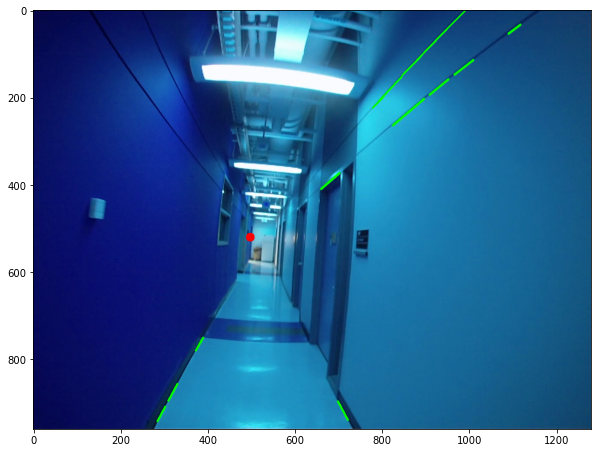

In [117]:
# Read corridor image
img = cv2.imread("Corridor1.jpg")           

# Get lines
lines = GetLines(img)

# Get vanishing point
vanishingPoint = GetVanishingPoint(lines)
print(f"Vanishing point @ {vanishingPoint}")

# Check if successfull
if vanishingPoint is None:
    raise Exception("No Vanishing Point found")
    
# Visualize result
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #result in normal colour
for line in lines:
    cv2.line(img, (line[0], line[1]), (line[2], line[3]), (0, 255, 0), 4)
cv2.circle(img, (int(vanishingPoint[0]), int(vanishingPoint[1])), 10, (255, 0, 0), -1)
plt.figure(figsize=(10, 10))
plt.imshow(img)

## Ex 4.3 Manhattan Frames (2 p)

In the following task you are dealing with a concept called "Manhattan World", which is the assumption that man-made environments (indoors) are fundamentally organized in three orthogonal directions (characterized by three vanishing points). You can find more information on the Manhattan World in this article: "The Manhattan Frame Model—Manhattan World Inference in the Space of Surface Normals" (https://ieeexplore.ieee.org/document/7839295).

In the following task you are given the information of 2 vanishing directions (imgX_directionY) inside 2 consecutive frames.
Your first task is to compute both frame's third orthogonal vanishing direction and aggregate all 3 directions in a 3x3 matrix (Manhattan directions are columns).

After calculating the 3 vanishing directions, we want to calculate the relative rotational movement (3 degrees of freedom) of the camera between the two given frames based on Manhattan frames. In this special case, the only major rotation axis is the roll axis.
We assume the camera started at the first frame at an absolute orientation of the identity matrix (start_orientation).
At this starting point you observed the first three manhattan directions. At the time of the second image, you observe the second manhattan directions. First, calculate the absolute rotation at step 2, before computing the SO3 relative rotation matrix based on the absolute orientation. 

The code to evaluate your solution visually is given below. The scipy spatial transform package converts the SO3 rotation matrix you computed into euler angles in degrees. From the result we extract the roll angle and apply that to the original image. In the plot you can visualize your result to see if the rotated second image resembles the first image.
Careful: The given Manhattan directions are real measurements from a smartphone and, therefore, contain noise. That means even with the correct computation, the visual result does not align pixel level exact (but it still gives a good idea on whether your computations are correct).

In [118]:
import numpy as np
import cv2
from scipy.ndimage import rotate
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R

In [119]:
img1 = cv2.imread("manhattan/1.jpg")
img2 = cv2.imread("manhattan/2.jpg")

In [120]:
start_orientation = np.array([[1,0,0],[0,1,0],[0,0,1]])

img1_direction1 = np.array([0.031,-0.98,-0.17])
img1_direction2 = np.array([0.96,0.01,0.03])

img2_direction1 = np.array([0.944,-0.3,-0.14])
img2_direction2 = np.array([0.001,1.0,0.001])

#3rd orthogonal vector
img1_direction3 = np.cross(img1_direction1, img1_direction2)
img2_direction3 = np.cross(img2_direction1, img2_direction2)

In [121]:
# assemble Manhattan Matrices
img1_matrix = np.transpose([img1_direction1, img1_direction2, img1_direction3])
img2_matrix = np.transpose([img2_direction1, img2_direction2, img2_direction3])

In [122]:
# compute absolute rotation at image 2
abs_r = img1_matrix @ img2_matrix

In [123]:
# calculate the realtive rotation from absolute orientation
so3 =  abs_r @ start_orientation 
r = R.from_matrix(so3)
r = r.as_euler('zyx', degrees=True)
roll = r[0] #as_euler has axes flipped around, hence we take z here as roll

In [124]:
#Be careful if you computed the rotation from image 1 -> image 2 or vica versa, try negating your angle
#roll=-roll
rotated= rotate(img1,roll,axes=(0,1), reshape=False,mode='constant',cval=0)

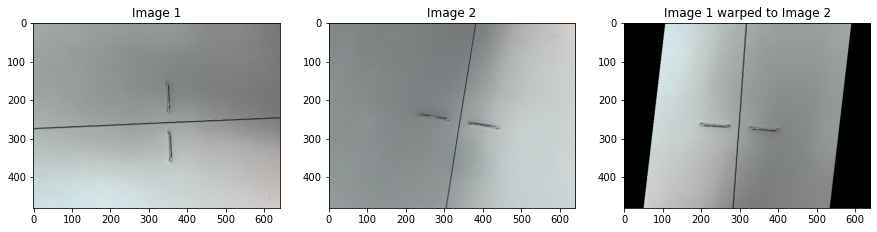

In [125]:
plt.figure(figsize=(15,30))
plt.subplot(1,3,1)
plt.title("Image 1")
plt.imshow(img1)
plt.subplot(1,3,2)
plt.title("Image 2")
plt.imshow(img2)
plt.subplot(1,3,3)
plt.title("Image 1 warped to Image 2")
plt.imshow(rotated)
plt.show()